# Определение стоимости автомобилей

**Описание компании:** «Не бит, не крашен» - сервис по продаже автомобилей с пробегом. Компания разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

**Цель:** Нам нужно построить модель для определения стоимости.

**Задача:** Добиться оптимальных и нужных заказчику:
- качества предсказания;
- скорости предсказания;
- времени обучения.

# Описание данных

**В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.**

**Признаки:**

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
**Целевой признак:** 

    Price — цена (евро)

## Подготовка данных

### Импортируем нужные библиотеки и будем обращаться к ним через принятные сокращения

In [1]:
# импортируем нужные библиотеки и будем обращаться к ним через принятные сокращения

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
import sklearn 
import random

sns.set()
warnings.filterwarnings('ignore')

### Через конструкцию try-except прочтем файл и сохраним ее в переменную df

In [2]:
# через конструкцию try-except прочтем файл и сохраним ее в переменную df
try:
    df = pd.read_csv("/datasets/autos.csv")
except FileNotFoundError:
    print("FileNotFoundError: Проверьте корректность пути к файлу или наличие самого файла в каталоге!")

### Выведем информацию об признаках, кол-ве ненулевых значений и типах данных

In [3]:
# выведем информацию об признаках, кол-ве ненулевых значений и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Выведем на экран размерность датасета 

In [4]:
# (строки, столбцы)
print("Размер :", df.shape)

Размер : (354369, 16)


### Выведем первые 5 строк 

In [5]:
# выведем первые 5 строк 
pd.set_option('display.max_columns', len(df.columns))
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Визуализируем признаки, чтобы увидеть и проанализировать потенциальные особенности в данных

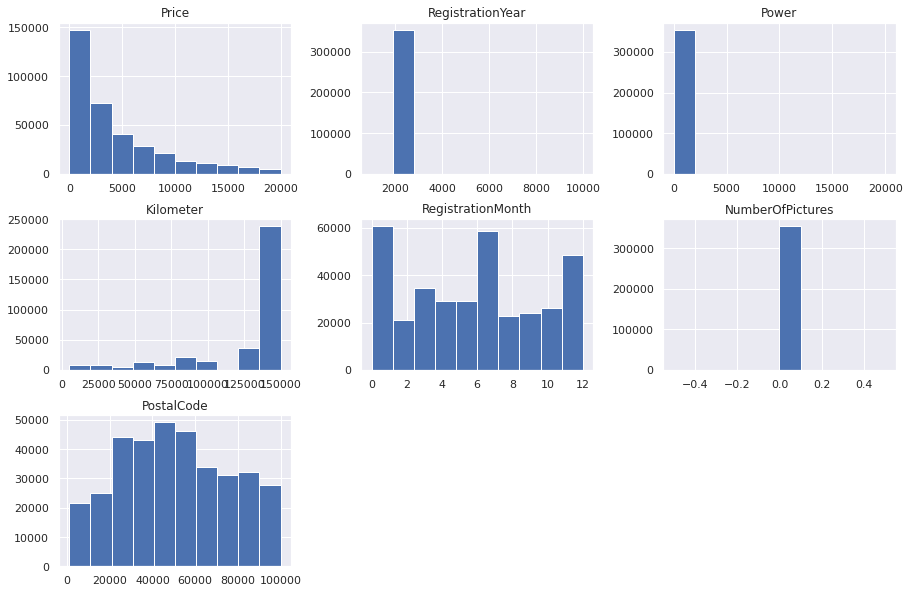

In [6]:
# визуализируем признаки, чтобы увидеть и проанализировать потенциальные особенности в данных
df.hist(figsize=(15,10));

### Выводы по графикам

1. Видем сразу, что у нас есть такая численная категория в признаке 'registration_mounth' как ноль. Что сведетельствует об потенциальной аномалии
2. На графике четко прослеживается то, что такие признаки как 'power', 'registration_year' и 'number_of_pictures' имеют одинаково распределение своих данных (в один столбец)
3. Видем, что для признака 'price' наибольшее кол-во признаков лежит ближе к нулю, и с последующим увелечением признака, данных все меньше. В то время как в признаке 'kilometer' мы видем сразу огромное распределение данных в 140000

### Переименуем столбцы в соотвествии с принятым стандартом: нижний и змеинный регистр

In [7]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gear_box', 'power', 
              'model', 'kilometer','registration_mounth', 'fuel_type', 'brand', 'repaired', 
              'date_created', 'number_of_pictures', 'postal_code', 'last_seen']
df.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_mounth,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Сразу заметили аномальное значение в признаке месяц, так как месяц не может быть 0 произведем соотвествующую замену

In [8]:
df['registration_mounth'] = df['registration_mounth'].replace(0, np.nan)

In [9]:
df['registration_mounth'] = df['registration_mounth'].fillna(random.choice([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]))
df.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_mounth,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,4.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Проверим через цикл кол-во и процент пропусков в наших признаков

In [10]:
for x in df.columns:
    print("Кол-во пропусков", x, "равняется", df[x].isna().sum())
    print("В процентах пропуски равняются:", df[x].isna().sum()/len(df[x]) * 100, "%")
    print()

Кол-во пропусков date_crawled равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков price равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков vehicle_type равняется 37490
В процентах пропуски равняются: 10.57936783409384 %

Кол-во пропусков registration_year равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков gear_box равняется 19833
В процентах пропуски равняются: 5.596708515699737 %

Кол-во пропусков power равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков model равняется 19705
В процентах пропуски равняются: 5.560587974681758 %

Кол-во пропусков kilometer равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков registration_mounth равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков fuel_type равняется 32895
В процентах пропуски равняются: 9.282696849893755 %

Кол-во пропусков brand равняется 0
В процентах пропуски равняются: 0.0 %

Кол-во пропусков repaired равняется 71154
В процентах пропуски 

### Поставим заглушку для наших пропусков в признаках

In [11]:
colm_to_replace = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'repaired']
for x in colm_to_replace:
    df[x] = df[x].fillna("-1")
df.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_mounth,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,-1,1993,manual,0,golf,150000,4.0,petrol,volkswagen,-1,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,-1,125000,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8.0,gasoline,jeep,-1,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Проверим дубликаты в датасете и произведем по необходимости их очистку

In [12]:
print('Кол-во дублирующих записей:', df.duplicated().sum())
print('Кол-во записей до избавления от дублирующих записей:',df.shape[0])

df = df.drop_duplicates().reset_index(drop=True)

print('Кол-во записей после избавления от дублирующих записей:',df.shape[0])

Кол-во дублирующих записей: 4
Кол-во записей до избавления от дублирующих записей: 354369
Кол-во записей после избавления от дублирующих записей: 354365


### Введем визуальное представление наших численных данных, чтобы найти потенциальные аномалии

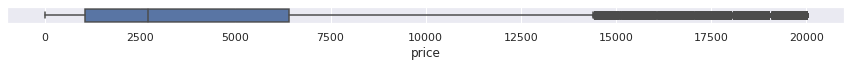

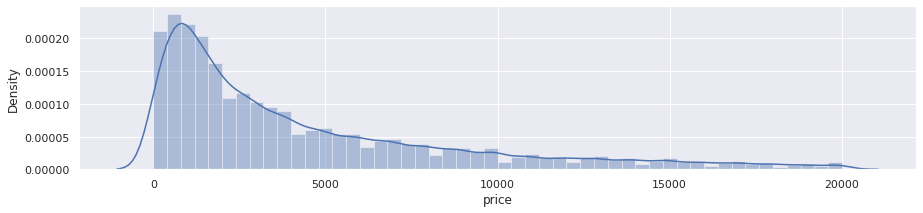

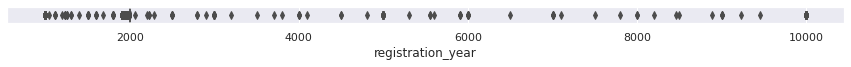

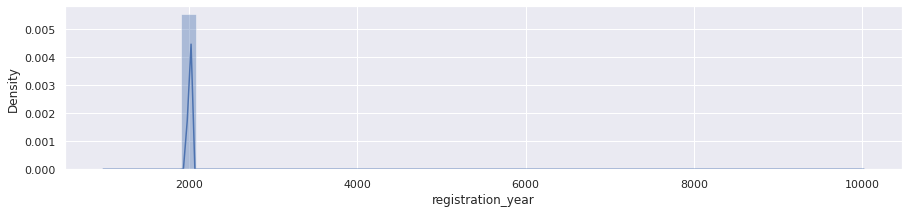

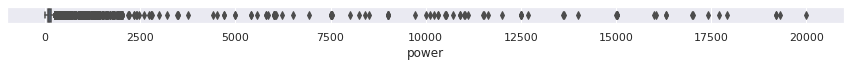

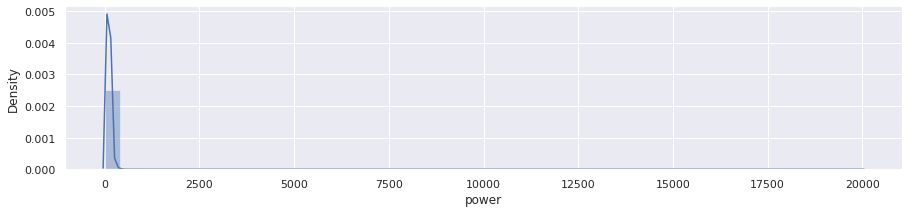

In [13]:
digits_columns = ['price', 'registration_year', 'power']
for i in df[digits_columns]:
    plt.figure(figsize=(15,.3))
    sns.boxplot(df[i])
    plt.show()
    plt.figure(figsize=(15,3))
    sns.distplot(df[i])
    plt.show()

### Создадим копию нашего датасета и будем работать с ней в дальнейшем

In [14]:
df_dub = df.copy()

### Исправим аномалии в признаке - регистрационный год

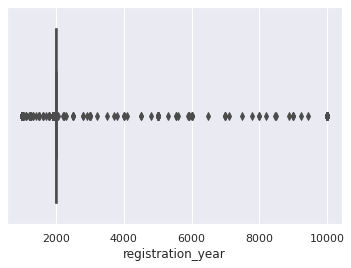

In [15]:
sns.boxplot(df_dub["registration_year"]);

### Посмотрим на год, который был максимальным вытащенным из базы данных

In [16]:
df_dub["date_crawled"].max()

'2016-04-07 14:36:58'

### Обработаем аномалии

In [17]:
df_dub = df_dub.query('1900 <= registration_year <= 2016')

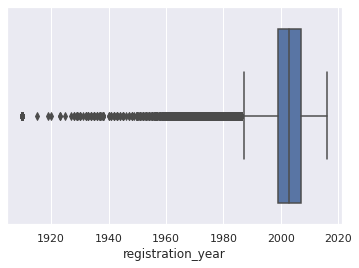

In [18]:
sns.boxplot(df_dub['registration_year']);

### Проверим долю признака registration_year после обработки аномалий

In [19]:
print("Доля данных, которые были удалены в ходе обработки аномалий:", 1 - (df_dub.shape[0] / df.shape[0]), "%")

Доля данных, которые были удалены в ходе обработки аномалий: 0.04118916935927641 %


### Произведем обработку данных для признаков 'price' и 'power'

In [20]:
df_dub = df_dub.query('power > 20')

In [21]:
df_dub = df_dub.query('price > 400')

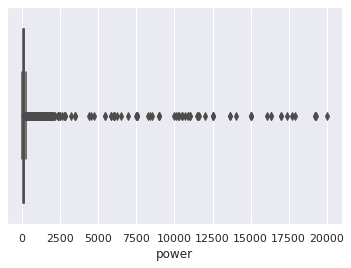

In [22]:
sns.boxplot(df_dub['power']);

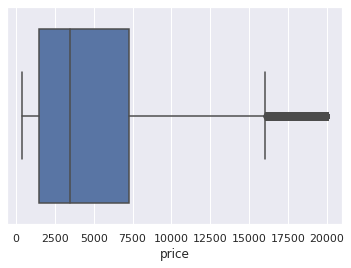

In [23]:
sns.boxplot(df_dub['price']);

### Проверим измененые минимальные значения в признаках

In [24]:
df_dub.describe()

,price,registration_year,power,kilometer,registration_mounth,number_of_pictures,postal_code
count,282006.000000,282006.000000,282006.000000,282006.000000,282006.000000,282006.0,282006.000000
mean,5089.688244,2003.044212,126.387517,127877.864301,6.269771,0.0,51403.024634
std,4607.081058,6.449093,191.458392,36823.387307,3.301216,0.0,25732.857948
min,408.000000,1910.000000,21.000000,5000.000000,1.000000,0.0,1067.000000
25%,1500.000000,1999.000000,82.000000,125000.000000,4.000000,0.0,31134.000000
50%,3499.000000,2003.000000,116.000000,150000.000000,6.000000,0.0,50672.000000
75%,7300.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72175.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Удаляем лишние и ненужные признаки

In [25]:
df_dub = df_dub.drop(["date_crawled", "date_created", "last_seen", "postal_code", 'number_of_pictures'], axis=1)

In [26]:
df = df.drop(["date_crawled", "date_created", "last_seen", "postal_code", 'number_of_pictures'], axis=1)

### Проведем проверку сохраности наших данных

In [27]:
print("Доля исходных данных, которые остались после обработки аномалий:", df_dub.shape[0] / df.shape[0] * 100, "%")

Доля исходных данных, которые остались после обработки аномалий: 79.58065836072976 %


### Выводы по первичному анализу

1. Были обнаружены пропуски в данных, для которых мы решили поставить заглушку в качестве обработки пропусков
2. Было обнаружено аномальное значение в столбце месяц - "0", для которого замена была на случайный месяц
3. Были приведены к правильному оформлению названия столбцов-признаков (через нижний и змеинный регистр)
4. Наибольшее кол-во пропусков в признаке repaired (~20%)
5. Признаки в датасете как количественные, так и категориальные. Что сведетельствует о том, что к данным должна быть приведена техника One-Hot-Encoding (OHT), OE и масштабирование данных.
6. Не все признаки нам будут нужны для обучения моделей, и в датасете присутствуют признаки, которые должны были быть представленны как datetime

1. Видем сразу, что у нас есть такая численная категория в признаке 'registration_mounth' как ноль. Что сведетельствует об потенциальной аномалии
2. На графике четко прослеживается то, что такие признаки как 'power', 'registration_year' и 'number_of_pictures' имеют одинаково распределение своих данных (в один столбец)
3. Видем, что для признака 'price' наибольшее кол-во признаков лежит ближе к нулю, и с последующим увелечением признака, данных все меньше. В то время как в признаке 'kilometer' мы видем сразу огромное распределение данных в 140000
10. Были обнаружены дубликаты и от них мы решили избавиться.

****

## Обучение моделей

### Разделим признаки и целевой признак

In [28]:
X = df_dub.drop(["price"], axis=1)
y = df_dub['price']

### Разделим на обучающую, валидационную и тренировочную выборки в соотношении 3:1:1

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

In [30]:
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

### Проверим корретность разделенных выборок

In [31]:
X_train.shape

(169203, 10)

In [32]:
X_test.shape

(56401, 10)

In [33]:
X_validate.shape

(56402, 10)

### Применим технику OrdinalEncoder (OE)

In [34]:
encoder = OrdinalEncoder(handle_unknown='ignore')

cat_columns = ['vehicle_type', 'gear_box', 'model',  'fuel_type', 'brand', 'repaired']

X_train_oe = X_train.copy()
X_test_oe = X_test.copy()
X_validate_oe = X_validate.copy()


X_train_oe[cat_columns] = encoder.fit_transform(X_train[cat_columns])
X_test_oe[cat_columns] = encoder.transform(X_test[cat_columns])
X_validate_oe[cat_columns] = encoder.transform(X_validate[cat_columns])

### Проверим корретность разделенных выборок для OrdinalEncoder (OE)

In [35]:
X_train_oe.shape

(169203, 10)

In [36]:
X_test_oe.shape

(56401, 10)

In [37]:
X_validate_oe.shape

(56402, 10)

# OneHotEncoder из sklearn

### Применим технику One-Hot-Encoding (OHT)

In [38]:
cat = list(X_train.select_dtypes('object').columns)
num = list(X_train.select_dtypes(exclude='object').columns)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=[num], index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num]), columns=[num], index=X_test.index)

enc = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = enc.fit_transform(X_train[cat])
X_test_ohe = enc.transform(X_test[cat])

X_train_lr = pd.concat([X_train_scaled, pd.DataFrame(X_train_ohe.toarray(), index=X_train.index)], axis=1)
X_test_lr  = pd.concat([X_test_scaled, pd.DataFrame(X_test_ohe.toarray(), index=X_test.index)], axis=1)

In [39]:
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[num]), columns=[num], index=X_validate.index)
X_validate_ohe = enc.transform(X_validate[cat])
X_validate_lr  = pd.concat([X_validate_scaled, pd.DataFrame(X_validate_ohe.toarray(), index=X_validate.index)], axis=1)

In [40]:
X_train_lr

,"(registration_year,)","(power,)","(kilometer,)","(registration_mounth,)",0,1,2,3,...,304,305,306,307,308,309,310,311
74574,-0.778860,-0.007338,0.601969,-0.080768,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
126596,0.302974,-0.141979,0.601969,-1.293780,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
333939,1.075712,-0.291580,-1.840268,0.828992,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68500,-0.315217,-0.221766,-0.754829,-0.080768,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
341359,-0.006122,-0.082139,0.601969,1.435499,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150583,-2.015242,-0.371367,0.601969,0.222486,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
325588,-0.933408,0.047515,0.601969,0.222486,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
165763,0.921165,-0.361393,0.601969,-1.597034,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
184558,0.148426,-0.122032,0.601969,-0.687274,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Проверим корретность разделенных выборок для One-Hot-Encoding (OHT)

In [41]:
X_train_lr.shape

(169203, 316)

In [42]:
X_test_lr.shape

(56401, 316)

In [43]:
X_validate_lr.shape

(56402, 316)

### Модель DecisionTreeRegressor

# Подбор гиперпараметров для моделей через GridSearchCV

In [44]:
%%time  

model_decision = DecisionTreeRegressor(random_state=42)

parametrs  = {'max_depth' : [2, 3, 4, 5, 6],
             'min_samples_leaf' : [1, 2, 3, 4, 5]
}
    
grid = GridSearchCV(estimator=model_decision, param_grid = parametrs, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train_oe, y_train)
print(f"Получили лучшие гиперпараметры: {grid.best_params_} - их и будем использовать как лучшие") 
print(-grid.best_score_)

Получили лучшие гиперпараметры: {'max_depth': 6, 'min_samples_leaf': 5} - их и будем использовать как лучшие
2311.276337378353
CPU times: user 16.8 s, sys: 35.9 ms, total: 16.9 s
Wall time: 16.9 s


### Выведем в табличной форме время обучения и предсказания нашей модели

In [45]:
results = pd.DataFrame(grid.cv_results_)
display(results)
display(results[results['rank_test_score'] == 1])
fit_time = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score'] == 1]['mean_score_time'].values[0]
print(f'Fit Time:{fit_time}, Predict Time:{predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.079877,0.009280,0.004108,0.000174,2,1,"{'max_depth': 2, 'min_samples_leaf': 1}",-3207.989225,-3219.614480,-3191.083301,-3224.086415,-3211.637577,-3210.882199,11.415256,21
1,0.069914,0.000296,0.004201,0.000310,2,2,"{'max_depth': 2, 'min_samples_leaf': 2}",-3207.989225,-3219.614480,-3191.083301,-3224.086415,-3211.637577,-3210.882199,11.415256,21
2,0.072458,0.002635,0.004307,0.000312,2,3,"{'max_depth': 2, 'min_samples_leaf': 3}",-3207.989225,-3219.614480,-3191.083301,-3224.086415,-3211.637577,-3210.882199,11.415256,21
3,0.070587,0.002696,0.003958,0.000063,2,4,"{'max_depth': 2, 'min_samples_leaf': 4}",-3207.989225,-3219.614480,-3191.083301,-3224.086415,-3211.637577,-3210.882199,11.415256,21
4,0.070298,0.002017,0.004255,0.000419,2,5,"{'max_depth': 2, 'min_samples_leaf': 5}",-3207.989225,-3219.614480,-3191.083301,-3224.086415,-3211.637577,-3210.882199,11.415256,21
5,0.102511,0.003399,0.004314,0.000240,3,1,"{'max_depth': 3, 'min_samples_leaf': 1}",-2944.129766,-2944.791018,-2918.039956,-2966.881578,-2951.851146,-2945.138693,15.832185,16
6,0.099869,0.001423,0.004268,0.000189,3,2,"{'max_depth': 3, 'min_samples_leaf': 2}",-2944.129766,-2944.791018,-2918.039956,-2966.881578,-2951.851146,-2945.138693,15.832185,16
7,0.099769,0.002714,0.004241,0.000068,3,3,"{'max_depth': 3, 'min_samples_leaf': 3}",-2944.129766,-2944.791018,-2918.039956,-2966.881578,-2951.851146,-2945.138693,15.832185,16
8,0.100069,0.003903,0.004118,0.000303,3,4,"{'max_depth': 3, 'min_samples_leaf': 4}",-2944.129766,-2944.791018,-2918.039956,-2966.881578,-2951.851146,-2945.138693,15.832185,16
9,0.100343,0.003100,0.004339,0.000136,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",-2944.129766,-2944.791018,-2918.039956,-2966.881578,-2951.851146,-2945.138693,15.832185,16


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,0.188357,0.003202,0.004917,0.000222,6,5,"{'max_depth': 6, 'min_samples_leaf': 5}",-2313.708233,-2320.305256,-2292.957245,-2307.546573,-2321.86438,-2311.276337,10.478954,1


Fit Time:0.18835721015930176, Predict Time:0.004917049407958984


****

### Модель LGBMRegressor

### Приведем категориальные признаки из 'object' в 'category', чтобы модели основанные на бустинге могли обучаться без кодирования и масштабирования выборок

In [46]:
list_category = list(X_train.select_dtypes('object').columns)
for x in list_category:
    X_train[x] = X_train[x].astype('category')
    X_validate[x] = X_validate[x].astype('category')
    X_test[x] = X_test[x].astype('category')

### Проверим контроль после

In [47]:
X_train.dtypes

vehicle_type           category
registration_year         int64
gear_box               category
power                     int64
model                  category
kilometer                 int64
registration_mounth     float64
fuel_type              category
brand                  category
repaired               category
dtype: object

In [48]:
X_test.dtypes

vehicle_type           category
registration_year         int64
gear_box               category
power                     int64
model                  category
kilometer                 int64
registration_mounth     float64
fuel_type              category
brand                  category
repaired               category
dtype: object

In [49]:
X_validate.dtypes

vehicle_type           category
registration_year         int64
gear_box               category
power                     int64
model                  category
kilometer                 int64
registration_mounth     float64
fuel_type              category
brand                  category
repaired               category
dtype: object

### Подберем гиперпараметры через оптимизатор GridSearchCV

In [50]:
%%time
param_grid = {'max_depth':[2,10],
              'learning_rate': [0.1, 0.8],
}

lgb_estimator = LGBMRegressor(random_state=42) 
                                

lgbm_grid = GridSearchCV(estimator = lgb_estimator,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               verbose=10,\
                               scoring= 'neg_root_mean_squared_error',\
                               cv=3)

lgbm_grid.fit(X_train, y_train)
print('best params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)


# best params {'learning_rate': 0.1, 'max_depth': 10}
# best score -1615.0591027803448
# CPU times: user 44min 1s, sys: 27.8 s, total: 44min 29s
# Wall time: 1h 7min 47s

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 1/3; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  48.8s
[CV 2/3; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 2/3; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  42.5s
[CV 3/3; 1/4] START learning_rate=0.1, max_depth=2..............................
[CV 3/3; 1/4] END ............learning_rate=0.1, max_depth=2; total time=  42.7s
[CV 1/3; 2/4] START learning_rate=0.1, max_depth=10.............................
[CV 1/3; 2/4] END ...........learning_rate=0.1, max_depth=10; total time= 5.4min
[CV 2/3; 2/4] START learning_rate=0.1, max_depth=10.............................
[CV 2/3; 2/4] END ...........learning_rate=0.1, max_depth=10; total time= 5.7min
[CV 3/3; 2/4] START learning_rate=0.1, max_depth=10.............................
[CV 3/3; 2/4] END ...........learning_rate=0.1, m

### Выведем в табличной форме время обучения и предсказания нашей модели

In [51]:
results = pd.DataFrame(lgbm_grid.cv_results_)
display(results)
display(results[results['rank_test_score'] == 1])
fit_time = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score'] == 1]['mean_score_time'].values[0]
print(f'Fit Time:{fit_time}, Predict Time:{predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,44.354128,2.929700,0.312913,0.009939,0.1,2,"{'learning_rate': 0.1, 'max_depth': 2}",-1912.638099,-1906.168791,-1901.660525,-1906.822471,4.505349,4
1,340.491078,12.979828,0.775861,0.039440,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",-1625.264154,-1610.566064,-1609.347090,-1615.059103,7.233200,1
2,54.025712,4.654253,0.372460,0.080693,0.8,2,"{'learning_rate': 0.8, 'max_depth': 2}",-1783.736854,-1760.938755,-1795.343375,-1780.006328,14.291188,3
3,682.821551,33.942394,0.805404,0.083842,0.8,10,"{'learning_rate': 0.8, 'max_depth': 10}",-1684.414751,-1672.130860,-1666.484351,-1674.343320,7.485365,2


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,340.491078,12.979828,0.775861,0.03944,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",-1625.264154,-1610.566064,-1609.34709,-1615.059103,7.2332,1


Fit Time:340.49107758204144, Predict Time:0.7758607069651285


# Модель LinearRegression

**Получим целевую метрику для линейной регресии**

In [52]:
ml_model = LinearRegression() 
v_f = cross_val_score(ml_model, X_train_lr, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(v_f.mean())

-18030480295.138847


In [53]:
from sklearn.model_selection import cross_validate

lr = LinearRegression()

scores = cross_validate(lr, X_train_lr, y_train, cv = 5, scoring='neg_root_mean_squared_error', return_estimator=True)
results_lr = pd.DataFrame(scores)
results_lr

,fit_time,score_time,estimator,test_score
0,29.890859,0.108588,LinearRegression(),-2.773398e+03
1,38.302257,0.194549,LinearRegression(),-2.781724e+03
2,40.304391,0.200662,LinearRegression(),-2.735374e+03
3,41.189139,0.104800,LinearRegression(),-2.737208e+10
4,33.292801,0.109263,LinearRegression(),-6.278031e+10


In [54]:
results_lr.test_score = results_lr.test_score * (-1) #для удобства уберу минус в колонке с метрикой  

#выведем все необходимые нам характеристики плюс минимальное и максимальное
#значение RMSE которое встречалось в кросс-валидации

display(f'Время обучения: {results_lr.fit_time.mean()}')
display(f'Время предсказания: {results_lr.score_time.mean()}')
display(f'RMSE среднее: {results_lr.test_score.mean()}')
display(f'RMSE минимальное: {results_lr.test_score.min()}')
display(f'RMSE максимальное: {results_lr.test_score.max()}')

'Время обучения: 36.595889472961424'

'Время предсказания: 0.14357247352600097'

'RMSE среднее: 18030480295.138847'

'RMSE минимальное: 2735.373518963183'

'RMSE максимальное: 62780313658.33342'

**Выведем отдельно время обучения и время предсказания**

In [55]:
%%time
model = LinearRegression()
model.fit(X_train_lr, y_train)

CPU times: user 13 s, sys: 14.6 s, total: 27.5 s
Wall time: 38.4 s


LinearRegression()

In [56]:
%%time
y_pred = model.predict(X_test_lr)

CPU times: user 80.9 ms, sys: 106 ms, total: 187 ms
Wall time: 809 ms


# Таблица с временем обучения и предскзания лучших моделей

**LGBMRegressor** 

    Fit Time:  352.6199272473653

    Predict Time:  0.7807518641153971
        
**LinearRegression** 

    Fit Time: 15.1 s           

    Predict Time: 195 ms

**DecisionTreeRegressor**

    Fit Time:  0.19026827812194824

    Predict Time:  0.004828691482543945

# Целевые метрики, полученные от разных моделей 

**LGBMRegressor:**  1614.3457311713319

**LinearRegression:** 25283242004.54427

**DecisionTreeRegressor:** 2311.276337378353

****

### Конечные выводы по обучению модели

1. Разделили на обучающую, валидационную и тренировочную выборки в соотношении 3:1:1
2. Проверили корретность разделенных выборок
3. Произвели масштабирование данных для 
4. Произвели подбор гиперпараметров для моделей через GridSearchCV
5. Выбрали модели LGBMRegressor, LinearRegression и DecisionTreeRegressor в качестве моделей
6. После выбрали модель LGBMRegressor как самую оптимальную под критерии заказчика

****

## Анализ моделей

**Опираясь на критерии заказчика, выбераем LGBMRegressor как лучшую модель, проверим её качество на тестовой выборке**

**Отобранные нами гиперпараметры:** 

    max_depth=10
    learning_rate=0.1

In [57]:
rmse_test = mean_squared_error(y_test, lgbm_grid.best_estimator_.predict(X_test)) ** 0.5
print(f"RMSE {lgb_estimator}:", rmse_test)

RMSE LGBMRegressor(random_state=42): 1616.9514339307655


### Выводы по анализу моделей 

1. Получили метрику качества RMSE чуть более лучшую, чем на валидационной выборке 
2. Модель была проверена на адекватность
3. RMSE = 1613.6627344779229

## Конечные выводы по проекту

**1. Выводы по первичному анализу:**

1. Были обнаружены пропуски в данных, для которых мы решили поставить заглушку в качестве обработки пропусков
2. Было обнаружено аномальное значение в столбце месяц - "0", для которого замена была на случайный месяц
3. Были приведены к правильному оформлению названия столбцов-признаков (через нижний и змеинный регистр)
4. Наибольшее кол-во пропусков в признаке repaired (~20%)
5. Признаки в датасете как количественные, так и категориальные. Что сведетельствует о том, что к данным должна быть приведена техника One-Hot-Encoding (OHT), OE и масштабирование данных.
6. Не все признаки нам будут нужны для обучения моделей, и в датасете присутствуют признаки, которые должны были быть представленны как datetime
7. Видем сразу, что у нас есть такая численная категория в признаке 'registration_mounth' как ноль. Что сведетельствует об потенциальной аномалии
8. На графике четко прослеживается то, что такие признаки как 'power', 'registration_year' и 'number_of_pictures' имеют одинаково распределение своих данных (в один столбец)
9. Видем, что для признака 'price' наибольшее кол-во признаков лежит ближе к нулю, и с последующим увелечением признака, данных все меньше. В то время как в признаке 'kilometer' мы видем сразу огромное распределение данных в 140000
10. Были обнаружены дубликаты и от них мы решили избавиться.

**2. Конечные выводы по обучению модели**

1. Разделили на обучающую, валидационную и тренировочную выборки в соотношении 3:1:1
2. Проверили корретность разделенных выборок
3. Произвели масштабирование данных
4. Создадили собственную метрику качества: RMSE
5. Произвели подбор гиперпараметров для моделей через GridSearchCV
6. Выбрали модели LGBMRegressor, LinearRegression и DecisionTreeRegressor в качестве моделей
7. После выбрали модель LGBMRegressor как самую оптимальную под критерии заказчика


**Параметры лучшей модели LGBMRegressor:**

    max_depth=10
    learning_rate=0.1
    RMSE = 1614.3457311713319


**3.  Выводы по анализу моделей**
1. Получили метрику качества RMSE чуть более лучшую
2. Модель была проверена на адекватность
3. RMSE = 1613.6627344779229